In [1]:
# -*- coding: utf-8 -*-
"""
@author: 
Justine Gouraud
Bastien Lepreux
Timothe Renard
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
###############################################################################
""" 
    Definition of the constants
    Unit of time: day 
    Unit of distance : a.u
    Unit of mass: M0
"""
###############################################################################

#Sun
M = 1                               # Mass of the sun
k = 0.01720209895 
G = k**2

# Jupiter
MJ = 1/1047.348625                  # ratio M(Sun)/M(Jupiter) 
aJ = 5.202575                       # AU
eJ = 0.048908
iJ = np.radians(1.3038)             # conversion deg to rad
omegaJ = np.radians(100.5145)       # rad
wJ = np.radians(273.8752)           # rad

MoJ = np.radians(80.0392)           # rad (depending on epoch)
epoch = 2456600.5                   # (2013/11/04 0h)

TJ = 2*np.pi*(aJ**(3/2))/np.sqrt(G) # orbital period (days)

# Asteroid
a = 5.454
e = 0.3896
i = 108.358*np.pi/180
w = 226.107*np.pi/180
omega = 276.509*np.pi/180
Mo = 146.88*np.pi/180

# Setting time
h = 2
N = int(1000*TJ/h)
t = np.linspace(epoch,epoch+1000*TJ,N)


In [3]:
###############################################################################
"""
            Description of an elliptical orbit
"""
###############################################################################

# Definition of the eccentric anomaly (Newton Method)
def Ecc_ano(M,e):
    x = M
    epsilon = 0.0001
    def f(x):
        return x-e*np.sin(x)-M
    
    while abs(f(x))>epsilon:
        x = x - f(x)/(1-e*np.cos(x))
    return x

# Definition of the rotational matrix 
def R1(x):
    R = np.zeros([3,3])
    R[0,0] = 1
    R[1,1] = np.cos(x)
    R[1,2] = np.sin(x)
    R[2,1] = -np.sin(x)
    R[2,2] = np.cos(x)
    return R

def R3(x):
    R = np.zeros([3,3])
    R[0,0] = np.cos(x)
    R[0,1] = np.sin(x)
    R[1,0] = -np.sin(x)
    R[1,1] = np.cos(x)
    R[2,2] = 1
    return R


# Definition of the elliptic orbit
def elliptic(t,a,e,i,omega,w,Mo):
    n = k/np.sqrt(a**3)
    
    # Initialization of the position vector u = (x,x_dot)
    x = np.zeros([N,3])
    x_dot = np.zeros([N,3])
    u = np.zeros([N,6])
    
    for j in range (0,N):
        M = Mo + n*(t[j]-epoch)
        while M>360:
            M = M - 360
        E = Ecc_ano(M,e)
        X = a*(np.cos(E)-e)
        Y = a*np.sqrt(1-e**2)*np.sin(E)
        r = a*(1-e*np.cos(E))
        X_dot = -n*a**2*np.sin(E)/r
        Y_dot = n*a**2*np.sqrt(1-e**2)*np.cos(E)/r
        
        x[j,:] = R3(-omega)@R1(-i)@R3(-w)@(X,Y,0)
        x_dot[j,:] = R3(-omega)@R1(-i)@R3(-w)@(X_dot,Y_dot,0)
        u[j,:] = [x[j,0],x[j,1],x[j,2],x_dot[j,0],x_dot[j,1],x_dot[j,2]]
    
    return u

Jupiter = elliptic(t,aJ,eJ,iJ,omegaJ,wJ,MoJ) 
Asteroid = elliptic(t,a,e,i,omega,w,Mo)



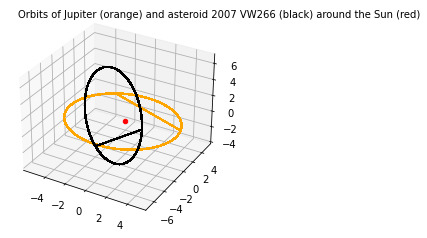

In [4]:

"""
            3D Graph of Jupiter and asteroid VW266 orbits without perturbations
"""

plt.figure(1)
ax = plt.axes(projection='3d') 
ax.text2D(0.05, 0.95, "Orbits of Jupiter (orange) and asteroid 2007 VW266 (black) around the Sun (red)", transform=ax.transAxes)
ax.plot3D(Jupiter[:,0],Jupiter[:,1],Jupiter[:,2],'orange',label='Jupiter') 
ax.plot3D(Asteroid[:,0],Asteroid[:,1],Asteroid[:,2],'black', label='Asteroid') 

ax.scatter(0,0,0,c='red',label='Sun')



In [5]:
###############################################################################
"""
            VW266 motion with Jupiter's perturbation
"""
###############################################################################

# Calculation of the position of Jupiter through time
def J(time):
    n = k/np.sqrt(aJ**3)
    
    x = np.zeros([3])
    x_dot = np.zeros([3])
    u = np.zeros([6])
    
    M = MoJ + n*(time-epoch)
    while M>=360:
        M = M%360
    E = Ecc_ano(M,eJ)
    X = aJ*(np.cos(E)-eJ)
    Y = aJ*np.sqrt(1-eJ**2)*np.sin(E)
    r = aJ*(1-eJ*np.cos(E))
    X_dot = -n*aJ**2*np.sin(E)/r
    Y_dot = n*aJ**2*np.sqrt(1-eJ**2)*np.cos(E)/r
        
    x = R3(-omegaJ)@R1(-iJ)@R3(-wJ)@(X,Y,0)
    x_dot = R3(-omegaJ)@R1(-iJ)@R3(-wJ)@(X_dot,Y_dot,0)
    u = [x[0],x[1],x[2],x_dot[0],x_dot[1],x_dot[2]]
    
    return u



def asteroid_motion_J(t):
    
    # Initial data
    u0 = Asteroid[0,:]

    # Implementation of the perturbation of Jupiter
    def f(y,t):
        z = J(t)
        r = np.sqrt(y[0]**2+y[1]**2+y[2]**2)
        rJ = np.sqrt(z[0]**2+z[1]**2+z[2]**2)
        delta_r = np.sqrt((y[0]-z[0])**2+(y[1]-z[1])**2+(y[2]-z[2])**2)
        add1 = - G*MJ*((y[0]-z[0])/delta_r**3 + z[0]/rJ**3)
        add2 = - G*MJ*((y[1]-z[1])/delta_r**3 + z[1]/rJ**3)
        add3 = - G*MJ*((y[2]-z[2])/delta_r**3 + z[2]/rJ**3)
        return np.array([y[3],y[4],y[5],-G*M*y[0]/r**3+add1,-G*M*y[1]/r**3+add2,-G*M*y[2]/r**3+add3])
    
    # Compute data
    y = np.zeros([N,6])
    y[0,:] = u0
    
    # Runge Kutta 4
    for i in range (1,N):
        k1 = f(y[i-1,:],t[i-1])
        k2 = f(y[i-1,:]+(h/2)*k1,t[i-1]+(h/2))
        k3 = f(y[i-1,:]+(h/2)*k2,t[i-1]+(h/2))
        k4 = f(y[i-1,:]+h*k3,t[i-1]+h)
    
        y[i,:] = y[i-1,:]+h/6*(k1+2*k2+2*k3+k4)
    return y

r_asteroid = asteroid_motion_J(t)

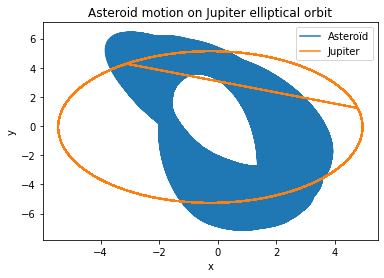

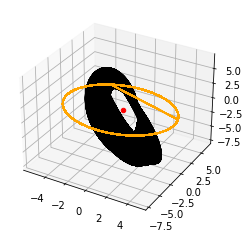

In [6]:
"""
        2D/3D Graph of Asteroid VW266 motion with perturbation
        
"""
plt.figure(2)
plt.plot(r_asteroid[:,0],r_asteroid[:,1])
plt.title('Asteroid motion on Jupiter elliptical orbit')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(Jupiter[:,0],Jupiter[:,1])
plt.legend(["Asteroïd","Jupiter"])

plt.figure(3)
ax = plt.axes(projection='3d') 
ax.plot3D(r_asteroid[:,0],r_asteroid[:,1],r_asteroid[:,2],'black', label='Asteroid') 
ax.plot3D(Jupiter[:,0],Jupiter[:,1],Jupiter[:,2],'orange',label='Jupiter') 
ax.scatter(0,0,0,c='red',label='Sun')

(2456600.5, 6790970.197021852, 95.0, 125.0)

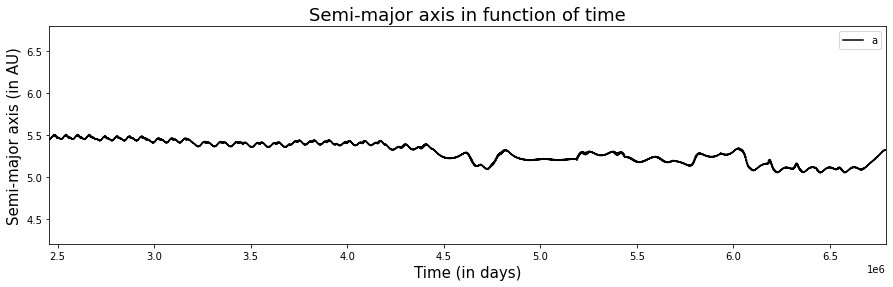

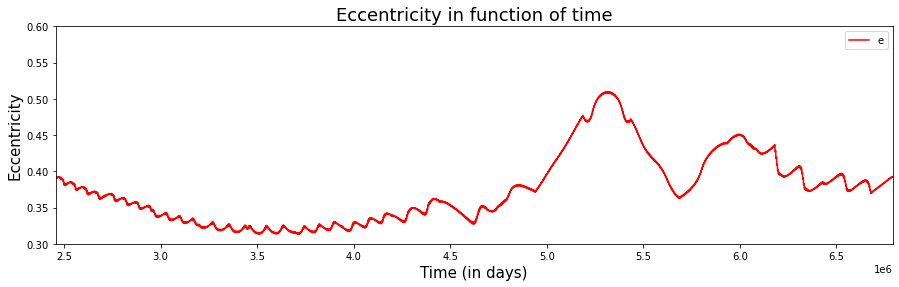

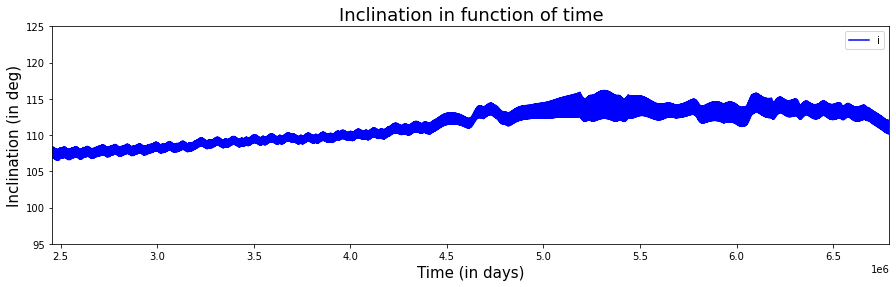

In [7]:
###############################################################################
"""
            Evolution of a, e and i parameters through time
"""
###############################################################################

def param(ast):
    para = np.zeros([N,3])
    
    for i in range (0,N):
        r = [ast[i,0],ast[i,1],ast[i,2]]
        r_dot = [ast[i,3],ast[i,4],ast[i,5]]
    
        r_abs = np.linalg.norm(r)
        r_dot_abs = np.linalg.norm(r_dot)
        k = np.cross(r,r_dot)/(r_abs*r_dot_abs)
    
        para[i,0] = 1/(2/r_abs - r_dot_abs**2/G)
        para[i,1] = np.linalg.norm(np.cross(r_dot,np.cross(r,r_dot))/G - r/r_abs)
        para[i,2] = np.arccos(k[2])*180/np.pi
        
    return para

a,e,i = param(r_asteroid)[:,0],param(r_asteroid)[:,1],param(r_asteroid)[:,2]

plt.close(1)
plt.figure(1, figsize=(15, 4))
plt.plot(t,a,'k')
plt.title('Semi-major axis in function of time',fontsize=18)
plt.xlabel('Time (in days)',fontsize=15)
plt.ylabel('Semi-major axis (in AU)',fontsize=15)
plt.legend(["a"])
plt.axis([t[0],t[N-1],4.2,6.8])

plt.close(2)
plt.figure(2, figsize=(15, 4))
plt.plot(t,e,'r')
plt.title('Eccentricity in function of time',fontsize=18)
plt.xlabel('Time (in days)',fontsize=15)
plt.ylabel('Eccentricity',fontsize=15)
plt.legend(["e"])
plt.axis([t[0],t[N-1],0.3,0.6])

plt.close(3)
plt.figure(3, figsize=(15, 4))
plt.plot(t,i,'b')
plt.title('Inclination in function of time',fontsize=18)
plt.xlabel('Time (in days)',fontsize=15)
plt.ylabel('Inclination (in deg)',fontsize=15)
plt.legend(["i"])
plt.axis([t[0],t[N-1],95,125])